In [1]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf, 
                        create_directory, read_directory_files, get_subdirectories,
                        get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                       )
from xml_document_info import (get_xml_info)
from box_spacings_operation import (update_horizontal_spacings_v1, update_vertical_spacings_v1)
from box_conditions_evaluation import (are_vlines_too_close, are_vlines_close_enough,
                                       are_hlines_too_close, are_hlines_close_enough,
                                       are_hlines_aligned, are_lines_fonts_similar,
                                       arrange_grouped_line_indices, are_hlines_superscript, get_lines_upper_lower,
                                       are_hlines, are_vlines, are_vlines_zero_overlap, are_vlines_full_overlap)

from box_horizontal_operation import (merge_hori_boxes_close)

import pandas as pd
from PIL import Image, ImageDraw, ImageFont


## Draw the boxes on document pages

In [2]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [3]:
base_dir   = '/Users/kd/Workspace/python/github/document-structure/data/'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
filename   = 'v241.pdf'


In [4]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
print(xml_files, "\n\n")

image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
print(image_files)

Extracted pdf images [/Users/kd/Workspace/python/github/document-structure/data/output/v241/images] 


Extracted xml of digital PDF [/Users/kd/Workspace/python/github/document-structure/data/output/v241/pdttohtml] 


['/Users/kd/Workspace/python/github/document-structure/data/output/v241/pdttohtml/v241.xml'] 


['/Users/kd/Workspace/python/github/document-structure/data/output/v241/images/v2410001-1.jpg', '/Users/kd/Workspace/python/github/document-structure/data/output/v241/images/v2410001-2.jpg', '/Users/kd/Workspace/python/github/document-structure/data/output/v241/images/v2410001-3.jpg']


In [5]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (3) in file (v241.xml)


In [6]:
document_configs = {
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 5.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

## Vertical box merging operations

In [7]:
def merge_vert_boxes(df, boxes, debug=False):
    t_ts       = []
    t_ls       = []
    t_ws       = []
    t_hs       = []
    texts      = []
    f_sizes    = []
    f_familys  = []
    f_colors   = []
    
    if debug:
        print('merge_vert_boxes: %s \n---------\n' % (str(boxes)))
        
    for box_item in boxes:
        line_indices, connection_type = box_item
        
        if connection_type == 'NOT_CONNECTED':
            for line_index in line_indices:
                t_ts.append(df.iloc[line_index]['text_top'])
                t_ls.append(df.iloc[line_index]['text_left'])
                t_hs.append(df.iloc[line_index]['text_height'])
                t_ws.append(df.iloc[line_index]['text_width'])
                texts.append(df.iloc[line_index]['text'])
                f_sizes.append(df.iloc[line_index]['font_size'])
                f_familys.append(df.iloc[line_index]['font_family'])
                f_colors.append(df.iloc[line_index]['font_color'])
        else:
            first_line_index = line_indices[0]
            last_line_index  = line_indices[-1]
            
            t_ts.append(df.iloc[first_line_index]['text_top'])
            
            min_left         = df.loc[first_line_index:last_line_index, 'text_left'].min()
            t_ls.append(min_left)

            t_hs.append(df.iloc[last_line_index]['text_top'] + df.iloc[last_line_index]['text_height'] - df.iloc[first_line_index]['text_top'])

            max_width        = max(df.iloc[first_line_index]['text_left']+df.iloc[first_line_index]['text_width'],
                                  df.iloc[last_line_index]['text_left']+df.iloc[last_line_index]['text_width']) - min_left
            t_ws.append(max_width)

            connected_text = ''
            for line_index in line_indices:
                connected_text = connected_text +  df.iloc[line_index]['text'] + ' '
            texts.append(connected_text)
            f_sizes.append(df.iloc[first_line_index]['font_size'])
            f_familys.append(df.iloc[first_line_index]['font_family'])
            f_colors.append(df.iloc[first_line_index]['font_color'])

    box_df = pd.DataFrame(list(zip(t_ts, t_ls, t_ws, t_hs, texts, 
                                   f_sizes, f_familys, f_colors)),
                          columns =['text_top', 'text_left', 'text_width', 'text_height', 'text', 
                                    'font_size', 'font_family', 'font_color'])
    
    box_df = update_horizontal_spacings_v1(box_df)
    box_df = update_vertical_spacings_v1(box_df)
    
    return box_df

def merge_vert_boxes_close(df, configs, debug=False):
    new_df             = df.copy()
    new_df             = new_df.reset_index(drop=True)
    
    connections        = []
    index_grams        = get_ngram(list(new_df.index.values), window_size=2)
    for index_gram in index_grams:
        if are_lines_fonts_similar(new_df, configs, index_gram[0], index_gram[1], debug=debug) \
        :
            connections.append((index_gram[1], index_gram[0], 'CONNECTED'))
        else:
            connections.append((index_gram[1], index_gram[0], 'NOT_CONNECTED'))
    
    if debug:
        print("line connections (merge_vert_boxes_close) : %s \n----\n" % (str(connections)))
    
    grouped_lines = arrange_grouped_line_indices(connections, debug=debug)
    new_df        = merge_vert_boxes(new_df, grouped_lines, debug=debug)
    
    '''
        - too close vertical lines have been merged till here
        - checking for overlap condition
    '''
    
#     connections        = []
#     index_grams        = get_ngram(list(new_df.index.values), window_size=2)
#     for index_gram in index_grams:
#         if are_lines_fonts_similar(new_df, configs, index_gram[0], index_gram[1], debug=debug) \
#             and \
#             are_vlines(new_df, configs, index_gram[0], index_gram[1], debug=debug) \
#         :
#             connections.append((index_gram[1], index_gram[0], 'CONNECTED'))
#         else:
#             connections.append((index_gram[1], index_gram[0], 'NOT_CONNECTED'))
    
#     grouped_lines = arrange_grouped_line_indices(connections, debug=debug)
#     box_df        = merge_vert_boxes(new_df, grouped_lines, debug=debug)
#     print('total records: %d, after merging records %d' % (new_df.shape[0], box_df.shape[0]))
    
    return new_df

In [8]:
file_index = 0

img        = image_files[file_index]
df         = xml_dfs[file_index]


total records: 25, after merging records 18


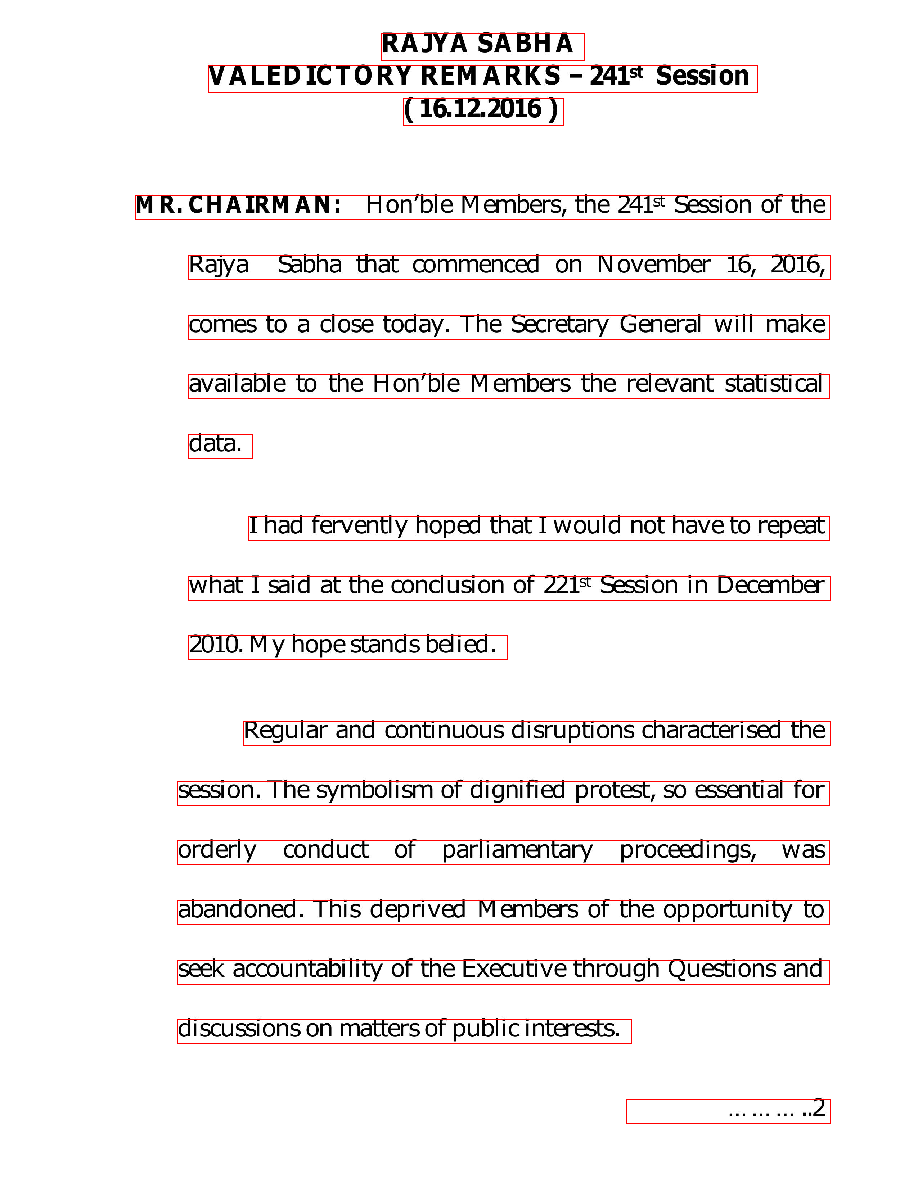

In [12]:
h_df = merge_hori_boxes_close(df, document_configs, debug=False)

# v_df = merge_vert_boxes_close(h_df, document_configs, debug=False)

draw_box(img, page_width, page_height, h_df, color='red')
# show_df(h_df)


In [11]:
def are_hlines_superscript_v1(df, configs, idx1, idx2, debug=False):
    
    if (abs(df.iloc[idx1]['text_top'] - df.iloc[idx2]['text_top']) <= configs['SUPERSCRIPT_HEIGHT_DIFFERENCE']):
        if df.iloc[idx1]['text_left'] < df.iloc[idx2]['text_left']:
            if df.iloc[idx1]['text_height'] < df.iloc[idx2]['text_height']:
                return True, idx1, idx2
        else:
            if df.iloc[idx1]['text_height'] < df.iloc[idx2]['text_height']:
                return True, idx2, idx1
            
            

#     if (df.iloc[idx1]['text_top'] >= df.iloc[idx2]['text_top']):
#         if  (df.iloc[idx1]['text_top'] - df.iloc[idx2]['text_top']) <= configs['SUPERSCRIPT_HEIGHT_DIFFERENCE']:
#             if df.iloc[idx1]['text_left'] > df.iloc[idx2]['text_left']:
#                 return True, idx1, idx2

#     if (df.iloc[idx2]['text_top'] >= df.iloc[idx1]['text_top']):
#         if  (df.iloc[idx2]['text_top'] - df.iloc[idx1]['text_top']) <= configs['SUPERSCRIPT_HEIGHT_DIFFERENCE']:
#             if df.iloc[idx2]['text_left'] > df.iloc[idx1]['text_left']:
#                 return True, idx1, idx2
    
    return False, idx1, idx2


print(are_hlines_superscript_v1(df, document_configs, 2, 3))


(True, 2, 3)


In [20]:

def get_vlines_overlap_condition(df, configs, idx1, idx2, debug=False):
    upper, lower  = get_lines_upper_lower(df, idx1, idx2)
    
    upper_left    = df.iloc[upper]['text_left']
    upper_right   = df.iloc[upper]['text_left'] + df.iloc[upper]['text_width']
    upper_width   = df.iloc[upper]['text_width']
    
    lower_left    = df.iloc[lower]['text_left']
    lower_right   = df.iloc[lower]['text_left'] + df.iloc[lower]['text_width']
    lower_width   = df.iloc[lower]['text_width']
    
    if (upper_left > lower_left) and ((upper_left - lower_left) > 10.0):
        if (lower_right < upper_left) and ((lower_right - upper_left) > 5.0):
            return 'NO_OVERLAPPING'
        
        if (lower_right <= upper_right) and ((lower_right - upper_right) > 5.0):
            return 'NO_OVERLAPPING'
        
        if (lower_right <= upper_right) and ((lower_right - upper_right) < 5.0):
            return 'OVERLAPPING'
        
    if (upper_left > lower_left) and ((upper_left - lower_left) < 10.0):
        if (lower_right < upper_left) and ((lower_right - upper_left) > 5.0):
            return 'NO_OVERLAPPING'
        
        if (lower_right <= upper_right) and ((lower_right - upper_right) > 5.0):
            return 'OVERLAPPING'
        
        if (lower_right <= upper_right) and ((lower_right - upper_right) < 5.0):
            return 'LEFT_OVERLAPPING'
    
    return 'OVERLAPPING'

In [58]:
# print(get_vlines_overlap_condition(h_df, document_configs, 7, 8))
show_df(df)


,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color
0,85,255,425,89,LOK SABHA,73,"ABCDEE+Tahoma,Bold",#000000
1,174,456,26,16,___,13,ABCDEE+Tahoma,#000000
2,205,289,367,34,BULLETIN – PART I,37,"Times New Roman,Bold",#000000
3,239,323,289,23,(Brief Record of Proceedings),19,"ABCDEE+Tahoma,Bold",#000000
4,262,453,35,22,___,18,ABCDEE+Tahoma,#000000
5,297,214,513,23,"Saturday, February 1, 2020/Magha 12, 1941 (Saka)",19,"ABCDEE+Tahoma,Bold",#000000
6,320,452,50,23,___,19,ABCDEE+Tahoma,#000000
7,351,436,69,23,No. 59,19,"ABCDEE+Tahoma,Bold",#000000
8,375,111,104,23,11.00 A.M.,19,"ABCDEE+Tahoma,Bold",#000000
9,410,111,24,23,1.,19,"ABCDEE+Tahoma,Bold",#000000


In [23]:
def findIntersection(x1,y1,x2,y2,x3,y3,x4,y4):
    px= ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) 
    py= ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
    return [px, py]

In [24]:
findIntersection(2,0, 2,8, 2,8, 4,8)

[2.0, 8.0]

In [51]:
def point_on_line(x, y, line):
    if (x >= line[0][0] and x <= line[1][0]) and (y >= line[0][1] and y <= line[1][1]):
        return True
    return False

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None, None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    
    if point_on_line(x, y, line1) and point_on_line(x, y, line2):
        return x, y
    
    return None, None

In [52]:
def get_vlines_overlap_condition_v1(df, configs, idx1, idx2, debug=False):
    upper, lower  = get_lines_upper_lower(df, idx1, idx2)
    
    upper_left    = df.iloc[upper]['text_left']
    upper_right   = df.iloc[upper]['text_left'] + df.iloc[upper]['text_width']
    upper_width   = df.iloc[upper]['text_width']
    
    lower_left    = df.iloc[lower]['text_left']
    lower_right   = df.iloc[lower]['text_left'] + df.iloc[lower]['text_width']
    lower_width   = df.iloc[lower]['text_width']
    
    upper_line1   = [[upper_left,  0], [upper_left,  df.iloc[upper]['text_top']]]
    upper_line2   = [[upper_right, 0], [upper_right, df.iloc[upper]['text_top']]]
    upper_line    = [[upper_left, df.iloc[upper]['text_top']], [upper_right, df.iloc[upper]['text_top']]]
#     print(upper_line1, upper_line2, upper_line)

    lower_line1   = [[lower_left,  0], [lower_left,  df.iloc[lower]['text_top']]]
    lower_line2   = [[lower_right, 0], [lower_right, df.iloc[lower]['text_top']]]
    lower_line    = [[lower_left, df.iloc[lower]['text_top']], [lower_right, df.iloc[lower]['text_top']]]
#     print(lower_line1, lower_line2, lower_line)
    
    print(line_intersection(upper_line1, lower_line))
    print(line_intersection(upper_line2, lower_line))

    print(line_intersection(lower_line1, upper_line))
    print(line_intersection(lower_line2, upper_line))



In [57]:
print(get_vlines_overlap_condition_v1(h_df, document_configs, 8, 9))


(None, None)
(None, None)
(111.0, 375.0)
(None, None)
None


In [31]:
h_df.head(10)

,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,horizontal_space,vertical_space
0,85,255,425,89,LOK SABHA,73,"ABCDEE+Tahoma,Bold",#000000,0,0
1,174,456,26,16,___,13,ABCDEE+Tahoma,#000000,0,0
2,205,289,367,34,BULLETIN – PART I,37,"Times New Roman,Bold",#000000,0,15
3,239,323,289,23,(Brief Record of Proceedings),19,"ABCDEE+Tahoma,Bold",#000000,0,0
4,262,453,35,22,___,18,ABCDEE+Tahoma,#000000,0,0
5,297,214,513,23,"Saturday, February 1, 2020/Magha 12, 1941 (Saka)",19,"ABCDEE+Tahoma,Bold",#000000,0,13
6,320,452,50,23,___,19,ABCDEE+Tahoma,#000000,0,0
7,351,436,69,23,No. 59,19,"ABCDEE+Tahoma,Bold",#000000,0,8
8,375,111,104,23,11.00 A.M.,19,"ABCDEE+Tahoma,Bold",#000000,0,1
9,410,111,295,23,1. Papers laid on the Table,19,"ABCDEE+Tahoma,Bold",#000000,0,12
